## Understanding Social Structure in Baboon Proximity Networks

### Set up 

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from datetime import timedelta
from scipy.spatial.distance import cdist
import re
from scipy.stats import spearmanr
from collections import defaultdict
import itertools
import imageio.v2 as imageio
import glob
from scipy.spatial.distance import jensenshannon

In [ ]:
df = pd.read_csv("baboon_group_dehoop.csv", index_col=0)
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df.head()

,Date,Time,Latitude,Longitude,UTM34S_East,UTM34S_North,Animal_ID,Datetime
Row,,,,,,,,
1,3/21/2007,7:02:00,-34.487999,20.412850,446089.6858,6183577.072,F9,2007-03-21 07:02:00
2,3/21/2007,7:02:00,-34.488000,20.412845,446089.2283,6183576.962,F7,2007-03-21 07:02:00
3,3/21/2007,7:04:00,-34.487910,20.412445,446052.3944,6183586.740,F5,2007-03-21 07:04:00
4,3/21/2007,7:04:00,-34.487869,20.412423,446050.3729,6183591.256,F1,2007-03-21 07:04:00
5,3/21/2007,7:05:00,-34.487816,20.412378,446046.1620,6183597.085,F11,2007-03-21 07:05:00


In [ ]:
len(df)

61841

In [ ]:
len(df["Date"].unique())

74

In [ ]:
df["Datetime"].min(), df["Datetime"].max()

(Timestamp('2007-03-21 05:06:00'), Timestamp('2008-04-14 16:26:00'))

### Data interpolation

In [ ]:
df = df.sort_values(by=["Animal_ID", "Datetime"])

target_times = df["Datetime"].sort_values().unique()

interpolated_records = []

for animal_id, df_ind in tqdm(df.groupby('Animal_ID')):
    df_ind = df_ind.sort_values('Datetime').reset_index(drop=True)

    for t in target_times:
        if (df_ind['Datetime'] == t).any():
            continue

        before = df_ind[df_ind['Datetime'] < t]
        after = df_ind[df_ind['Datetime'] > t]

        if before.empty or after.empty:
            continue

        t_before = before.iloc[-1]
        t_after = after.iloc[0]

        if (t_after['Datetime'] - t_before['Datetime']) > timedelta(minutes=10):
            continue

        total_delta = (t_after['Datetime'] - t_before['Datetime']).total_seconds()
        weight = (t - t_before['Datetime']).total_seconds() / total_delta

        east_interp = t_before['UTM34S_East'] + weight * (t_after['UTM34S_East'] - t_before['UTM34S_East'])
        north_interp = t_before['UTM34S_North'] + weight * (t_after['UTM34S_North'] - t_before['UTM34S_North'])

        interpolated_records.append({
            'Datetime': t,
            'Animal_ID': animal_id,
            'UTM34S_East': east_interp,
            'UTM34S_North': north_interp
        })

df_interpolated = pd.DataFrame(interpolated_records)

print(df_interpolated.head())


100%|██████████| 14/14 [07:32<00:00, 32.29s/it]


             Datetime Animal_ID   UTM34S_East  UTM34S_North
0 2007-03-21 05:39:00        F1  446619.59592  6.183329e+06
1 2007-03-21 05:40:00        F1  446621.44084  6.183327e+06
2 2007-03-21 05:45:00        F1  446627.19720  6.183320e+06
3 2007-03-21 05:46:00        F1  446627.30800  6.183320e+06
4 2007-03-21 05:47:00        F1  446627.41880  6.183319e+06


<ipython-input-11-831b27b5f11b>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('nipy_spectral', num_animals)


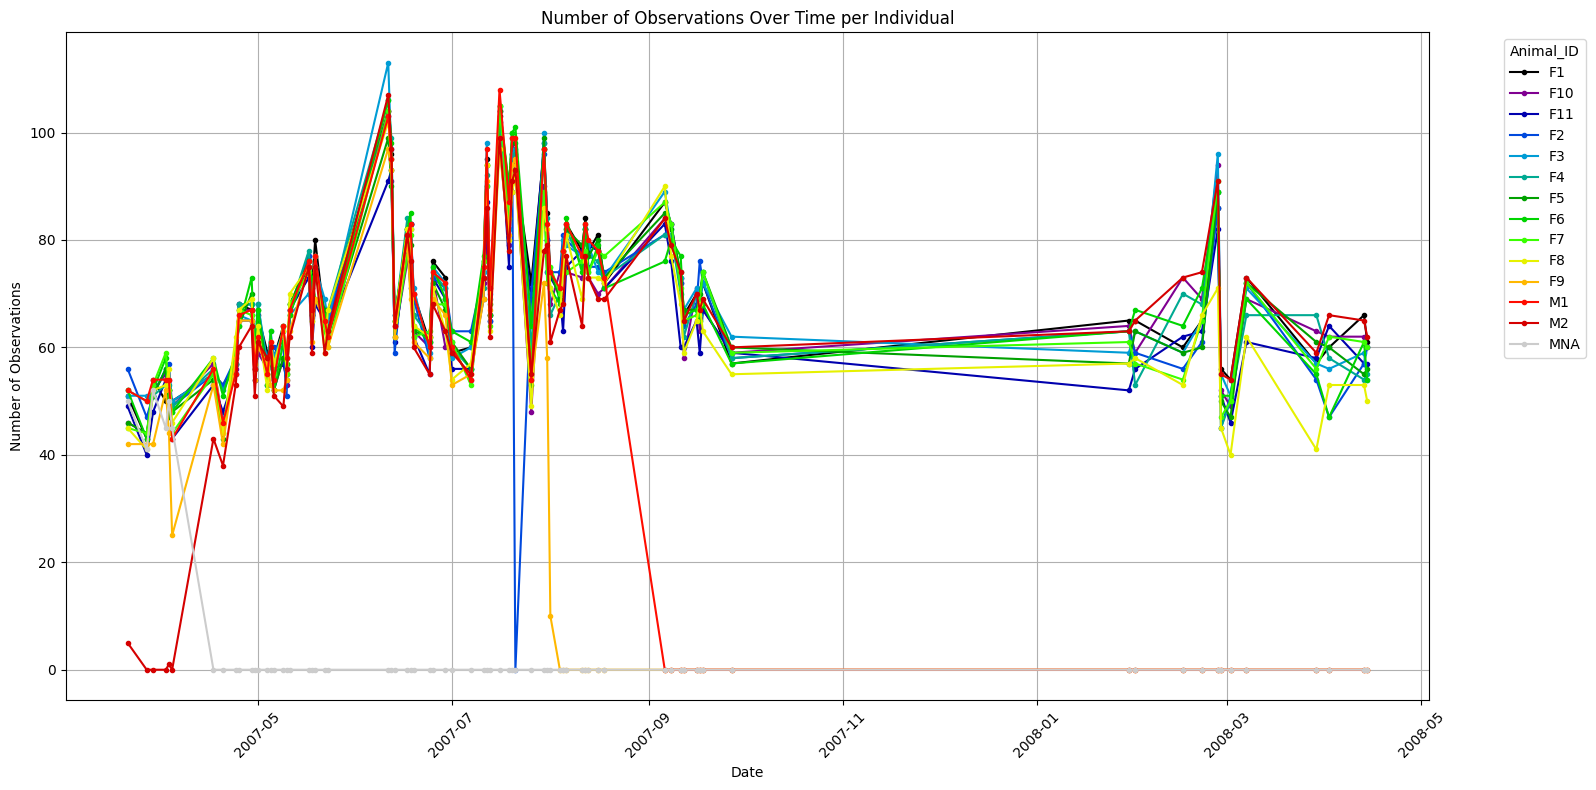

In [ ]:
obs_counts = df.groupby([df['Datetime'].dt.date, 'Animal_ID']).size().reset_index(name="Counts")

pivot_table = obs_counts.pivot(index="Datetime", columns="Animal_ID", values="Counts").fillna(0)

plt.figure(figsize=(16, 8))

num_animals = len(pivot_table.columns)
colors = cm.get_cmap('nipy_spectral', num_animals)

for i, animal in enumerate(pivot_table.columns):
    plt.plot(pivot_table.index, pivot_table[animal], label=animal,
             marker='o', markersize=3, linewidth=1.5, color=colors(i))

plt.title('Number of Observations Over Time per Individual')
plt.xlabel('Date')
plt.ylabel('Number of Observations')
plt.legend(title='Animal_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df['is_interpolated'] = False

df_interpolated['is_interpolated'] = True

df = pd.concat([df, df_interpolated], ignore_index=True)

df = df.sort_values(by=['Animal_ID', 'Datetime']).reset_index(drop=True)

df.head()

,Date,Time,Latitude,Longitude,UTM34S_East,UTM34S_North,Animal_ID,Datetime,is_interpolated
0,3/21/2007,5:38:00,-34.490241,20.418586,446617.75100,6.183332e+06,F1,2007-03-21 05:38:00,False
1,NaN,NaN,NaN,NaN,446619.59592,6.183329e+06,F1,2007-03-21 05:39:00,True
2,NaN,NaN,NaN,NaN,446621.44084,6.183327e+06,F1,2007-03-21 05:40:00,True
3,3/21/2007,5:43:00,-34.490345,20.418686,446626.97560,6.183320e+06,F1,2007-03-21 05:43:00,False
4,NaN,NaN,NaN,NaN,446627.19720,6.183320e+06,F1,2007-03-21 05:45:00,True


In [ ]:
len(target_times)

40591

In [ ]:
df_interpolated.to_csv("df_interpolated.csv")

In [ ]:
df_interpolated = pd.read_csv("df_interpolated.csv", index_col=0)

df_interpolated["Datetime"] = pd.to_datetime(df_interpolated["Datetime"])

df['is_interpolated'] = False

df_interpolated['is_interpolated'] = True

df = pd.concat([df, df_interpolated], ignore_index=True)

df = df.sort_values(by=['Animal_ID', 'Datetime']).reset_index(drop=True)

df.head()

,Date,Time,Latitude,Longitude,UTM34S_East,UTM34S_North,Animal_ID,Datetime,is_interpolated
0,3/21/2007,5:38:00,-34.490241,20.418586,446617.75100,6.183332e+06,F1,2007-03-21 05:38:00,False
1,NaN,NaN,NaN,NaN,446619.59592,6.183329e+06,F1,2007-03-21 05:39:00,True
2,NaN,NaN,NaN,NaN,446621.44084,6.183327e+06,F1,2007-03-21 05:40:00,True
3,3/21/2007,5:43:00,-34.490345,20.418686,446626.97560,6.183320e+06,F1,2007-03-21 05:43:00,False
4,NaN,NaN,NaN,NaN,446627.19720,6.183320e+06,F1,2007-03-21 05:45:00,True


In [ ]:
df = df[df["Animal_ID"] != "MNA"]
len(df)

347780

### Proximity network generation

In [ ]:
target_times = df["Datetime"].sort_values().unique()
df = df.sort_values(by=["Datetime"])

PROXIMITY_THRESHOLD = 5

all_individuals = df["Animal_ID"].unique()

temporal_networks = {}

for t in tqdm(target_times, desc="Processing Timepoints"):
    df_t = df[df["Datetime"] == t]

    G = nx.Graph()
    G.add_nodes_from(all_individuals)

    if df_t.empty or len(df_t) == 1:
        temporal_networks[t] = G
        continue

    coords = df_t[['UTM34S_East', 'UTM34S_North']].to_numpy()
    ids = df_t['Animal_ID'].to_numpy()

    # assert len(set(ids)) == len(ids)

    distances = cdist(coords, coords, metric='euclidean')

    n = len(ids)
    for i in range(n):
        for j in range(i + 1, n):
            if distances[i, j] <= PROXIMITY_THRESHOLD and ids[i] != ids[j]:
                G.add_edge(ids[i], ids[j], weight=1)

    temporal_networks[t] = G

print(f"\nGenerated {len(temporal_networks)} temporal networks.")
for time_t, G in list(temporal_networks.items())[:3]:
    print(f"Time t: {time_t}, Nodes: {len(G.nodes)}, Edges: {len(G.edges)}")


Processing Timepoints: 100%|██████████| 40539/40539 [01:14<00:00, 541.84it/s]



Generated 40539 temporal networks.
Time t: 2007-03-21 05:06:00, Nodes: 13, Edges: 1
Time t: 2007-03-21 05:08:00, Nodes: 13, Edges: 0
Time t: 2007-03-21 05:09:00, Nodes: 13, Edges: 0


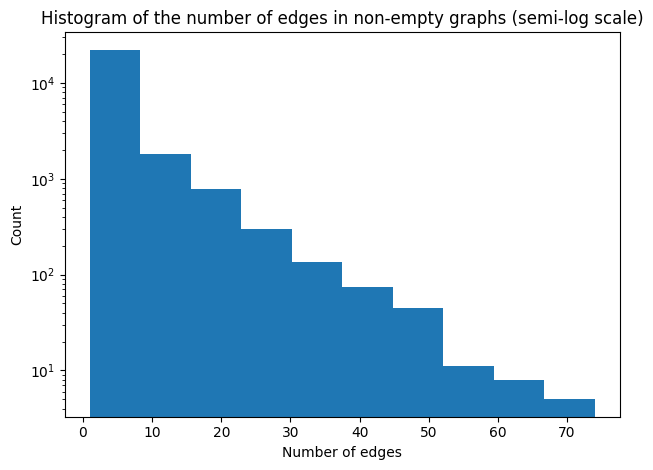

In [ ]:
num_edges = [len(G.edges) for G in temporal_networks.values()]
plt.hist(np.array(num_edges)[np.array(num_edges) > 0])
plt.xlabel("Number of edges")
plt.ylabel("Count")
plt.title("Histogram of the number of edges in non-empty graphs (semi-log scale)")
plt.yscale("log")
plt.tight_layout()

### Averaged network

In [ ]:
all_nodes = set().union(*[G.nodes for G in temporal_networks.values()])

co_occurrence_counts = {node: {other: 0 for other in all_nodes} for node in all_nodes}
proximity_counts = {node: {other: 0 for other in all_nodes} for node in all_nodes}

for t in tqdm(target_times, desc="Processing Time Bins"):
    df_t = df[df["Datetime"] == t]

    observed_ids = df_t["Animal_ID"].unique()

    G = temporal_networks[t]

    for i in range(len(observed_ids)):
        id1 = observed_ids[i]
        for j in range(i + 1, len(observed_ids)):
            id2 = observed_ids[j]

            co_occurrence_counts[id1][id2] += 1
            co_occurrence_counts[id2][id1] += 1

            if G.has_edge(id1, id2):
                proximity_counts[id1][id2] += 1
                proximity_counts[id2][id1] += 1

average_adjacency = {node: {} for node in all_nodes}

for node in all_nodes:
    for other in all_nodes:
        if node != other and co_occurrence_counts[node][other] > 0:
            weight = proximity_counts[node][other] / co_occurrence_counts[node][other]
            average_adjacency[node][other] = weight
        else:
            average_adjacency[node][other] = 0

average_adjacency_df = pd.DataFrame(average_adjacency).fillna(0)

G_avg = nx.Graph()

for node in average_adjacency:
    for neighbor, weight in average_adjacency[node].items():
        if weight > 0:
            G_avg.add_edge(node, neighbor, weight=weight)


Processing Time Bins: 100%|██████████| 40539/40539 [00:55<00:00, 735.44it/s]


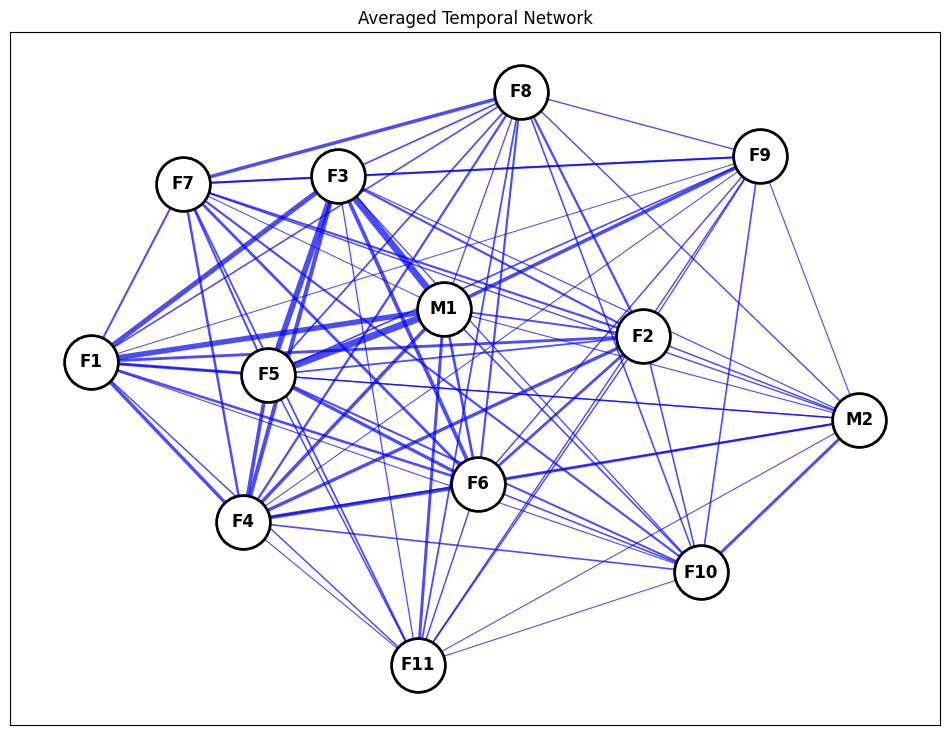

In [ ]:
plt.figure(figsize=(12, 9))

pos = nx.spring_layout(G_avg, seed=0)

edge_weights = [d['weight'] for _, _, d in G_avg.edges(data=True)]
edge_widths = [5 * w / max(edge_weights) for w in edge_weights]

nx.draw_networkx_edges(G_avg, pos, width=edge_widths, alpha=0.7, edge_color='blue')

nx.draw_networkx_nodes(G_avg, pos, node_size=1500, node_color="white", edgecolors="black", linewidths=2, alpha=1)

nx.draw_networkx_labels(G_avg, pos, font_size=12, font_color="black", font_weight="bold")

plt.title("Averaged Temporal Network")
plt.show()


### Correlation of node metrics with rank

In [ ]:
G_inv = G_avg.copy()
for u, v, data in G_inv.edges(data=True):
    if data['weight'] != 0:
        data['inv_weight'] = 1.0 / data['weight']
    else:
        data['inv_weight'] = float('inf')

strengths = {node: sum(data['weight'] for _, _, data in G_avg.edges(node, data=True)) for node in G_avg.nodes()}

clustering_coeffs = nx.clustering(G_avg, weight='weight')

betweenness_centrality = nx.betweenness_centrality(G_inv, weight='inv_weight')

closeness_centrality = nx.closeness_centrality(G_inv, distance='inv_weight')

eigenvector_centrality = nx.eigenvector_centrality(G_avg, weight='weight', max_iter=1000)

metrics_df = pd.DataFrame({
    'Node': list(G_avg.nodes()),
    'Strength': pd.Series(strengths),
    'ClusteringCoeff': pd.Series(clustering_coeffs),
    'BetweennessCentrality': pd.Series(betweenness_centrality),
    'ClosenessCentrality': pd.Series(closeness_centrality),
    'EigenvectorCentrality': pd.Series(eigenvector_centrality),
})

metrics_df.reset_index(drop=True, inplace=True)

metrics_df.head()


,Node,Strength,ClusteringCoeff,BetweennessCentrality,ClosenessCentrality,EigenvectorCentrality
0,F4,0.969516,0.344104,0.0,0.074299,0.318884
1,F3,1.095524,0.357366,0.0,0.072978,0.376584
2,F9,0.583906,0.251938,0.0,0.052292,0.190198
3,F8,0.686780,0.279956,0.0,0.053842,0.210575
4,F7,0.759453,0.296172,0.0,0.061014,0.229198


In [ ]:
def parse_hierarchy(animal_id):
    if animal_id.startswith('M'):
        nums = re.findall(r'\d+', animal_id)
        if nums:
            return ('M', int(nums[0]))
        else:
            return ('M', 999)
    elif animal_id.startswith('F'):
        nums = re.findall(r'\d+', animal_id)
        if nums:
            return ('F', int(nums[0]))
        else:
            return ('F', 999)
    else:
        return ('Z', 999)


In [ ]:
metrics_df[['Sex', 'Rank']] = metrics_df['Node'].apply(parse_hierarchy).apply(pd.Series)

In [ ]:
def permutation_spearman_pvalue(x, y, num_permutations=1000, alternative='two-sided'):
    rho_obs, _ = spearmanr(x, y)

    permuted_rhos = []

    for _ in range(num_permutations):
        y_permuted = np.random.permutation(y)
        rho_perm, _ = spearmanr(x, y_permuted)
        permuted_rhos.append(rho_perm)

    permuted_rhos = np.array(permuted_rhos)

    if alternative == 'greater':
        pval = np.mean(permuted_rhos >= rho_obs)
    elif alternative == 'less':
        pval = np.mean(permuted_rhos <= rho_obs)
    else:
        pval = np.mean(np.abs(permuted_rhos) >= np.abs(rho_obs))

    return rho_obs, pval

In [ ]:
metrics_df_f = metrics_df[metrics_df["Sex"] == "F"]

metrics = ['Strength', 'ClusteringCoeff', 'BetweennessCentrality', 'ClosenessCentrality', 'EigenvectorCentrality']

results = []

for metric in metrics:
    x = metrics_df_f['Rank']
    y = metrics_df_f[metric]

    rho, pval = permutation_spearman_pvalue(x, y, num_permutations=1000, alternative="less")

    results.append((metric, rho, pval))

permutation_test_results = pd.DataFrame(results, columns=['Metric', 'SpearmanRho', 'PermutationPValue'])

permutation_test_results


,Metric,SpearmanRho,PermutationPValue
0,Strength,-0.763636,0.003
1,ClusteringCoeff,-0.763636,0.003
2,BetweennessCentrality,-0.074536,0.466
3,ClosenessCentrality,-0.727273,0.002
4,EigenvectorCentrality,-0.818182,0.000


### Correlation of edge weight with rank difference

In [ ]:
edge_df = pd.DataFrame([
    {'node1': u, 'node2': v, 'weight': d.get('weight', 1)}
    for u, v, d in G_avg.edges(data=True)
])
edge_df[["sex1", "rank1"]] = edge_df["node1"].apply(parse_hierarchy).apply(pd.Series)
edge_df[["sex2", "rank2"]] = edge_df["node2"].apply(parse_hierarchy).apply(pd.Series)
edge_df_f = edge_df[(edge_df["sex1"] == "F") & (edge_df["sex2"] == "F")]
edge_df_f["rank_diff"] = (edge_df_f["rank1"] - edge_df_f["rank2"]).abs()
permutation_spearman_pvalue(edge_df_f["rank_diff"], edge_df_f["weight"])

<ipython-input-95-3516f8724ca5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_df_f["rank_diff"] = (edge_df_f["rank1"] - edge_df_f["rank2"]).abs()


(np.float64(-0.5592364541168434), np.float64(0.0))

### Average network by month

In [ ]:
graphs_by_month = defaultdict(dict)

for t, G in temporal_networks.items():
    month = t.strftime("%Y-%m")
    graphs_by_month[month][t] = G

monthly_aggregated_graphs = {}

for month, graphs in graphs_by_month.items():
    combined = nx.Graph()
    all_nodes_present_in_month = set()

    edge_counts = defaultdict(int)
    co_observation_counts = defaultdict(int)

    for t, G in graphs.items():
        for u, v in G.edges():
            edge = tuple(sorted((u, v)))
            edge_counts[edge] += 1

        obs = df[df["Datetime"] == t]

        observed_ids = set(obs["Animal_ID"])
        all_nodes_present_in_month = all_nodes_present_in_month.union(set(observed_ids))

        for u, v in itertools.combinations(observed_ids, 2):
            pair = tuple(sorted((u, v)))
            co_observation_counts[pair] += 1

    combined.add_nodes_from(all_nodes_present_in_month)

    for (u, v), count in edge_counts.items():
        combined.add_edge(u, v, weight=count / co_observation_counts[(u, v)])

    monthly_aggregated_graphs[month] = combined


In [ ]:
base_pos = nx.spring_layout(next(iter(monthly_aggregated_graphs.values())), seed=1)

im_list = []

for month, G in sorted(monthly_aggregated_graphs.items()):
    plt.figure(figsize=(10, 7))
    plt.title(f"Averaged Monthly Network – {month}", fontsize=14)

    edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]
    if edge_weights:
        edge_widths = [10 * w for w in edge_weights]
    else:
        edge_widths = []

    nx.draw_networkx_edges(G, base_pos, width=edge_widths, alpha=0.7, edge_color='blue')

    nx.draw_networkx_nodes(G, base_pos,
                           node_size=1500,
                           node_color="white",
                           edgecolors="black",
                           linewidths=2)

    nx.draw_networkx_labels(G, base_pos,
                            font_size=12,
                            font_color="black",
                            font_weight="bold")

    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"./whole_nw_monthly_animation/network_{month}.png", dpi=300)
    im_list.append(f"./whole_nw_monthly_animation/network_{month}.png")
    plt.close()


In [ ]:
images = []
for filename in im_list:
    images.append(imageio.imread(filename))

imageio.mimsave("whole_nw_animation/monthly_networks.mp4", images, fps=1)

### Average network by temporal block

In [ ]:
graphs_by_month = defaultdict(dict)
for t, G in temporal_networks.items():
    month = t.strftime("%Y-%m")
    graphs_by_month[month][t] = G

sorted_months = sorted(graphs_by_month.keys())

month_blocks = {
    'block1': sorted_months[:4],
    'block2': sorted_months[4:7],
    'block3': sorted_months[7:]
}

aggregated_graphs_by_block = {}

for block_name, month_list in month_blocks.items():
    combined = nx.Graph()
    all_nodes_present = set()

    edge_counts = defaultdict(int)
    co_observation_counts = defaultdict(int)

    for month in month_list:
        for t, G in graphs_by_month[month].items():
            for u, v in G.edges():
                edge = tuple(sorted((u, v)))
                edge_counts[edge] += 1

            obs = df[df["Datetime"] == t]
            observed_ids = set(obs["Animal_ID"])
            all_nodes_present.update(observed_ids)

            for u, v in itertools.combinations(observed_ids, 2):
                pair = tuple(sorted((u, v)))
                co_observation_counts[pair] += 1

    combined.add_nodes_from(all_nodes_present)

    for (u, v), count in edge_counts.items():
        if co_observation_counts[(u, v)] > 0:
            combined.add_edge(u, v, weight=count / co_observation_counts[(u, v)])

    aggregated_graphs_by_block[block_name] = combined


In [ ]:
month_blocks

{'block1': ['2007-03', '2007-04', '2007-05', '2007-06'],
 'block2': ['2007-07', '2007-08', '2007-09'],
 'block3': ['2008-01', '2008-02', '2008-03', '2008-04']}

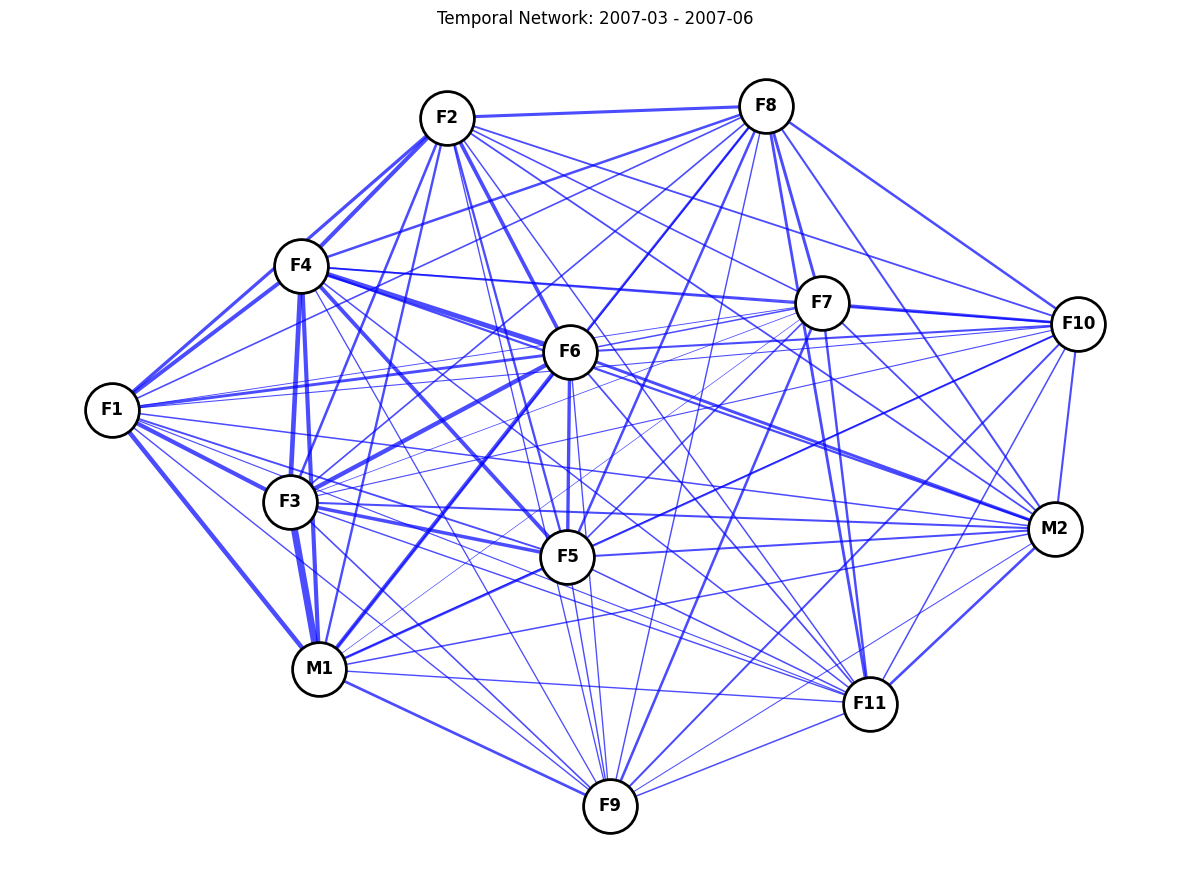

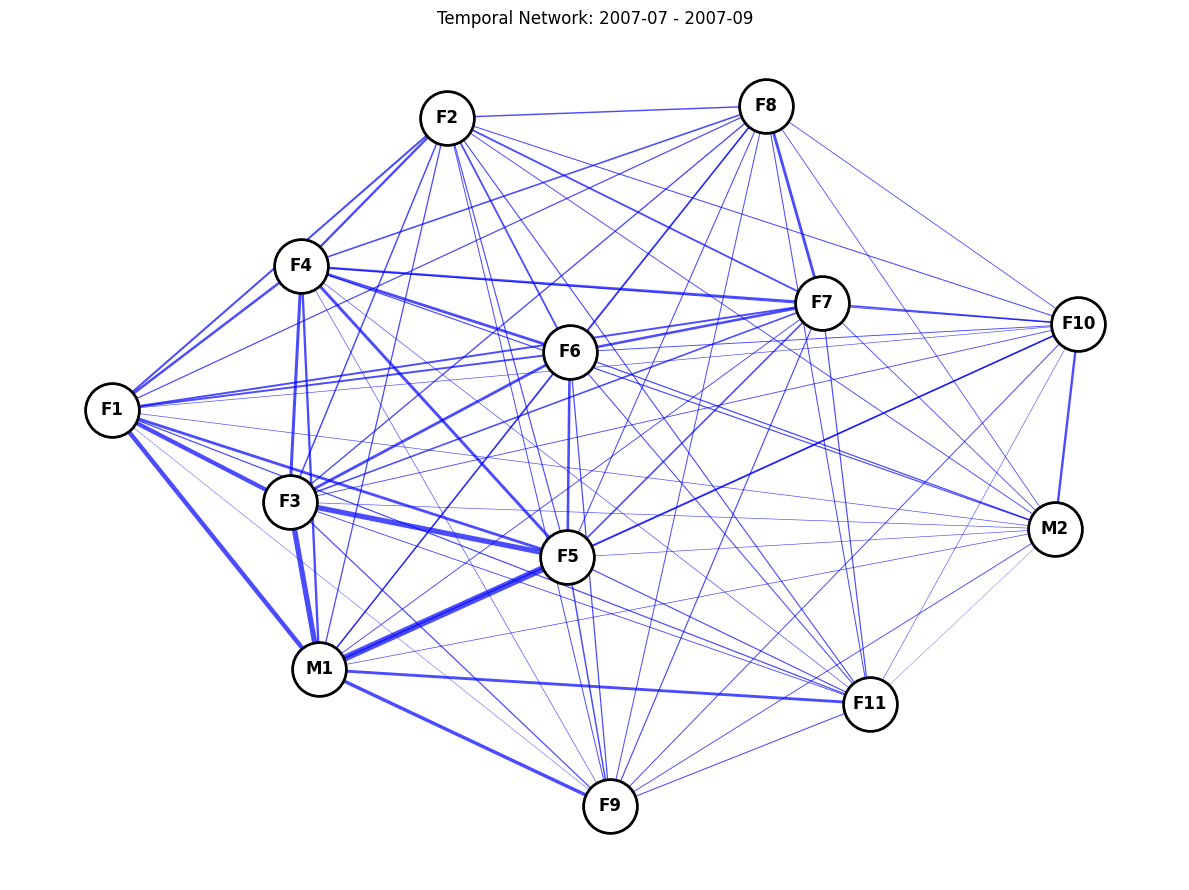

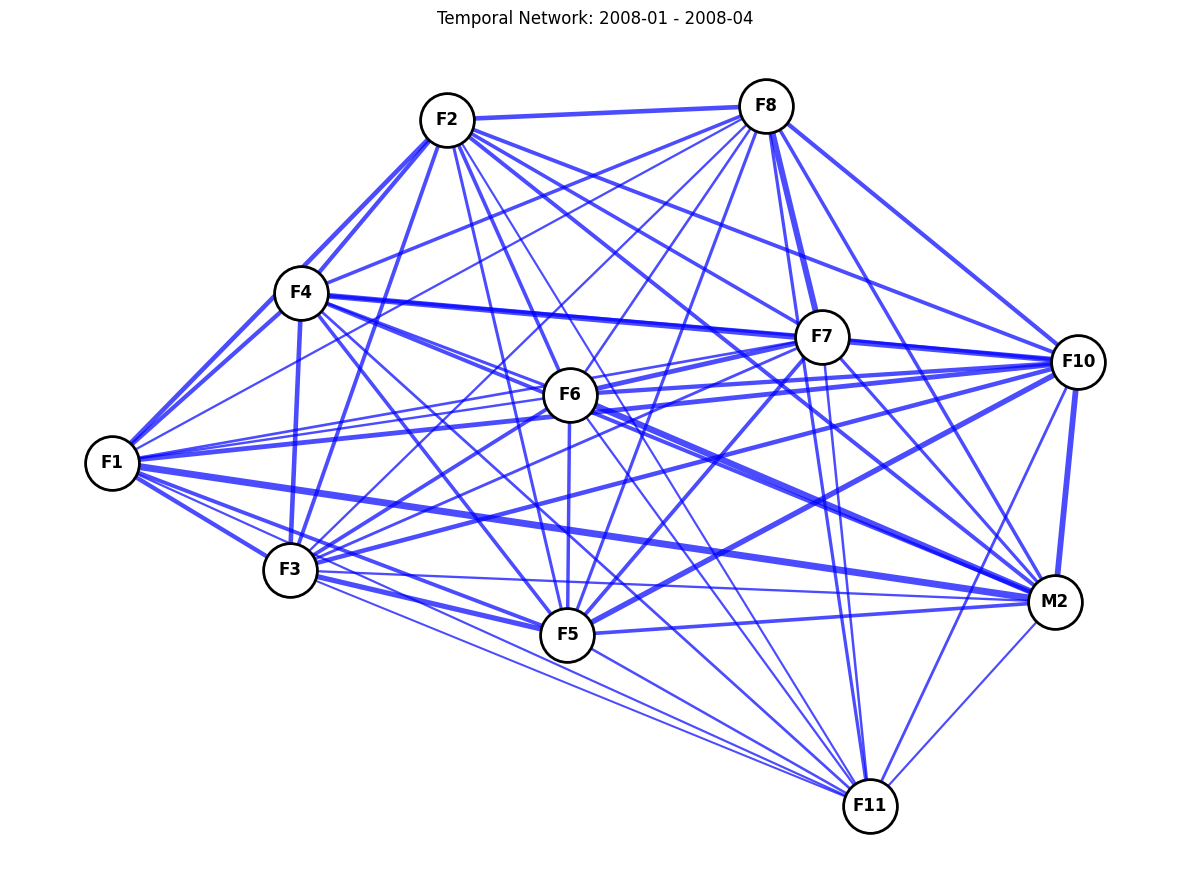

In [ ]:
pos = nx.spring_layout(G_avg, seed=0)

for block_name, G in aggregated_graphs_by_block.items():
    plt.figure(figsize=(12, 9))

    edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]
    if edge_weights:
        edge_widths = [5 * w / max(edge_weights) for w in edge_weights]
    else:
        edge_widths = []

    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='blue')

    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="white", edgecolors="black", linewidths=2, alpha=1)

    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black", font_weight="bold")

    plt.title(f"Temporal Network: {month_blocks[block_name][0]} - {month_blocks[block_name][-1]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


### Ego plots

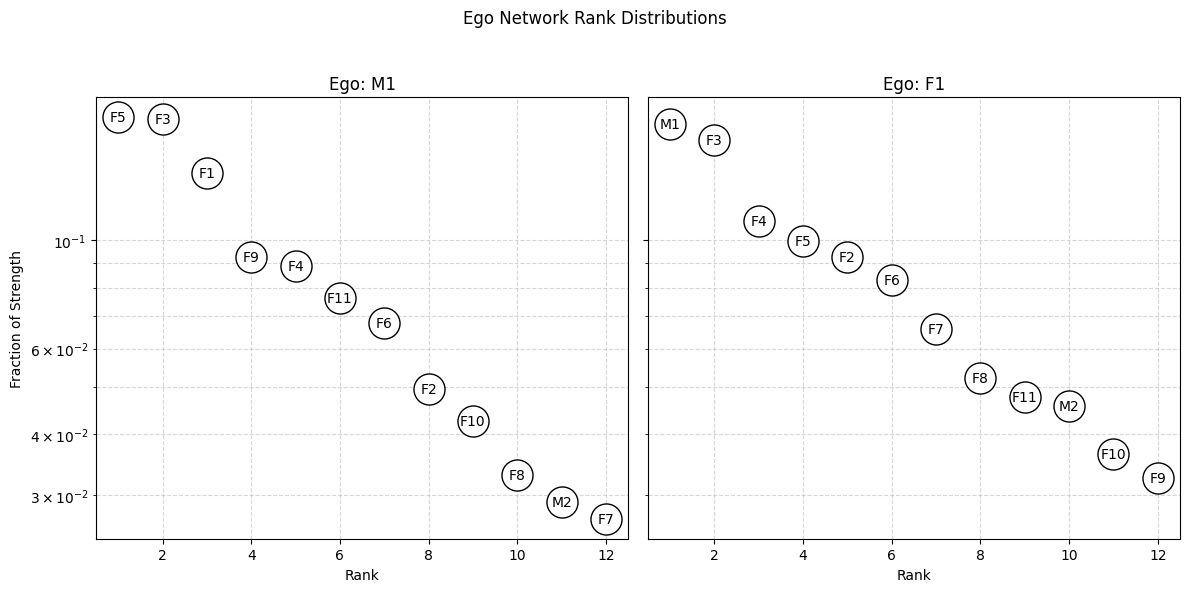

In [ ]:
def get_rank_distribution(G, ego_id):
    neighbors = list(G.neighbors(ego_id))
    edge_weights = [(n, G[ego_id][n]['weight']) for n in neighbors]
    edge_weights.sort(key=lambda x: x[1], reverse=True)

    total_strength = sum(w for _, w in edge_weights)
    fractions = [w / total_strength for _, w in edge_weights]
    labels = [n for n, _ in edge_weights]
    ranks = np.arange(1, len(fractions) + 1)

    return ranks, fractions, labels

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for ax, ego_id, title in zip(axs, ['M1', 'F1'], ['Ego: M1', 'Ego: F1']):
    ranks, fractions, labels = get_rank_distribution(G_avg, ego_id)

    ax.scatter(ranks, fractions, s=500, color='white', edgecolor='black', zorder=2)

    for r, f, label in zip(ranks, fractions, labels):
        ax.text(r, f, label, fontsize=10, ha='center', va='center', zorder=3)

    ax.set_title(title)
    ax.set_xlabel('Rank')
    ax.set_xlim(0.5, len(ranks) + 0.5)
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', alpha=0.5)

axs[0].set_ylabel('Fraction of Strength')
plt.suptitle("Ego Network Rank Distributions")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
for block_name, G in aggregated_graphs_by_block.items():
    print(G.nodes)

['F9', 'F5', 'F11', 'F6', 'F3', 'F7', 'F8', 'F2', 'M1', 'F10', 'F4', 'M2', 'F1']
['F9', 'F11', 'F5', 'F6', 'F3', 'F7', 'F2', 'F8', 'M1', 'F10', 'F4', 'M2', 'F1']
['F11', 'F5', 'F6', 'F3', 'F7', 'F8', 'F2', 'F10', 'F4', 'M2', 'F1']


In [ ]:
month_blocks

{'block1': ['2007-03', '2007-04', '2007-05', '2007-06'],
 'block2': ['2007-07', '2007-08', '2007-09'],
 'block3': ['2008-01', '2008-02', '2008-03', '2008-04']}

In [ ]:
def plot_ego_rank(node):
    for block_name, G in aggregated_graphs_by_block.items():
        if node not in G.nodes:
            continue

        fig, ax = plt.subplots(figsize=(6, 5))

        ranks, fractions, labels = get_rank_distribution(G, node)

        ax.scatter(ranks, fractions, s=500, color='white', edgecolor='black', zorder=2)

        for r, f, label in zip(ranks, fractions, labels):
            ax.text(r, f, label, fontsize=10, ha='center', va='center', zorder=3)

        ax.set_title(f"{block_name.upper()} - Ego: {node}")
        ax.set_xlabel('Rank')
        ax.set_xlim(0.5, len(ranks) + 0.5)
        ax.set_yscale('log')
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.set_ylabel('Fraction of Strength')

        plt.tight_layout()
        plt.show()


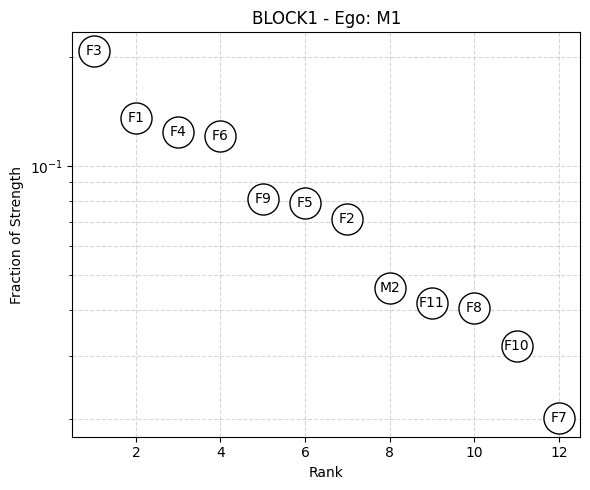

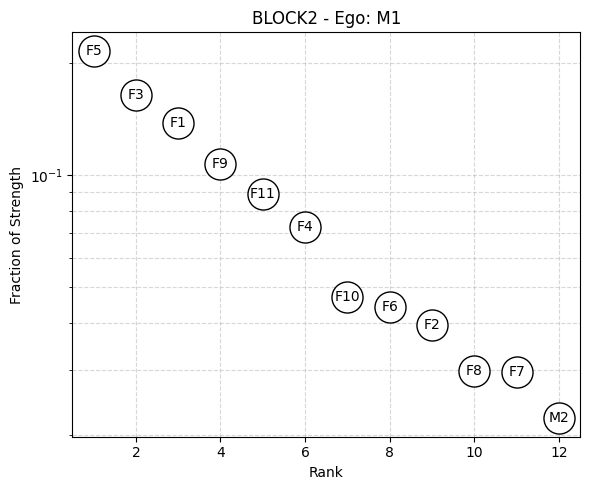

In [ ]:
plot_ego_rank("M1")

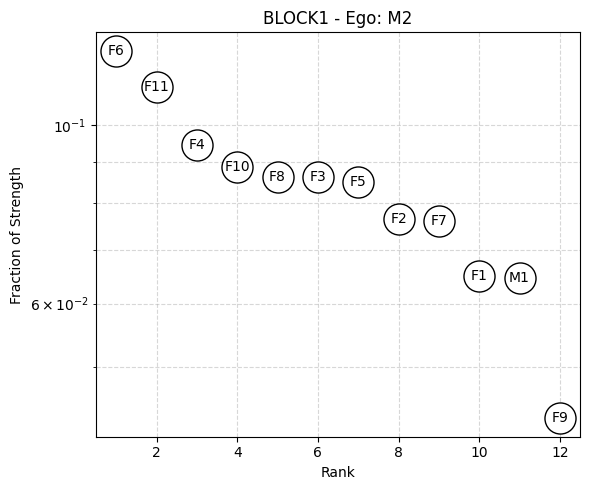

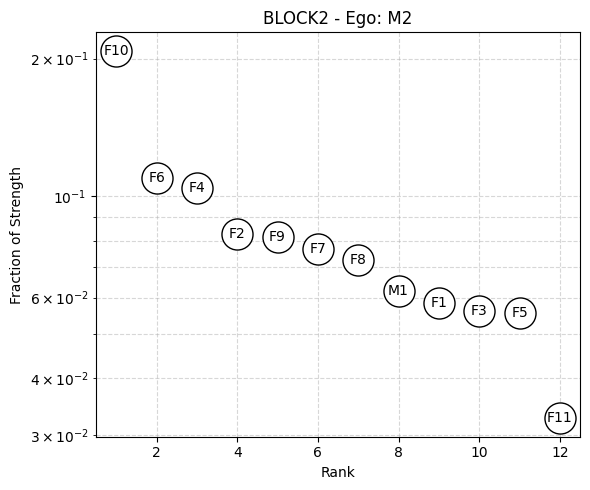

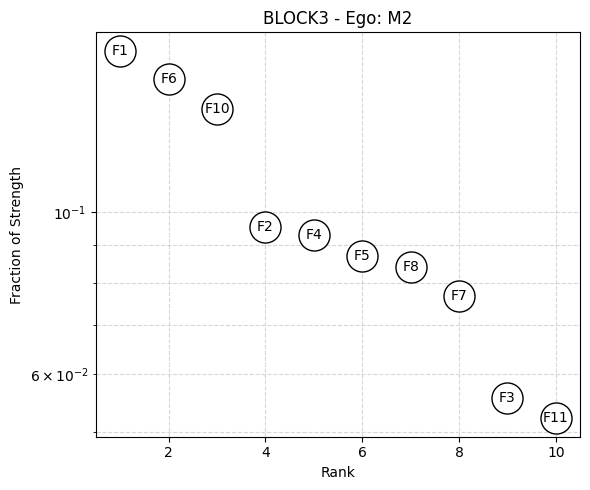

In [ ]:
plot_ego_rank("M2")

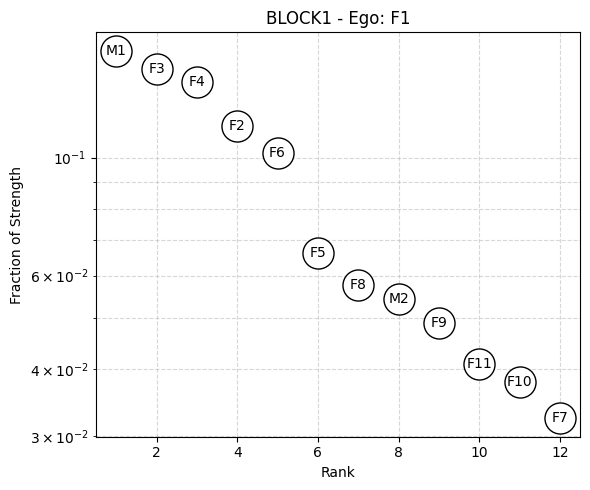

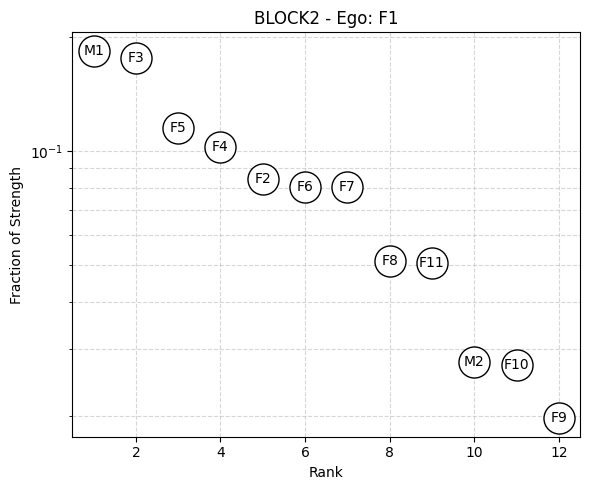

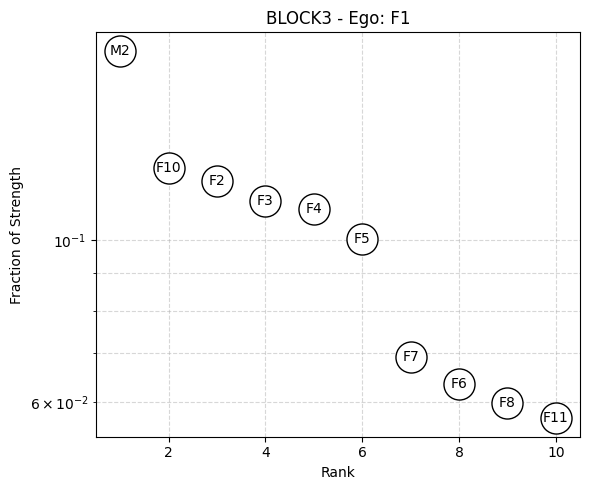

In [ ]:
plot_ego_rank("F1")

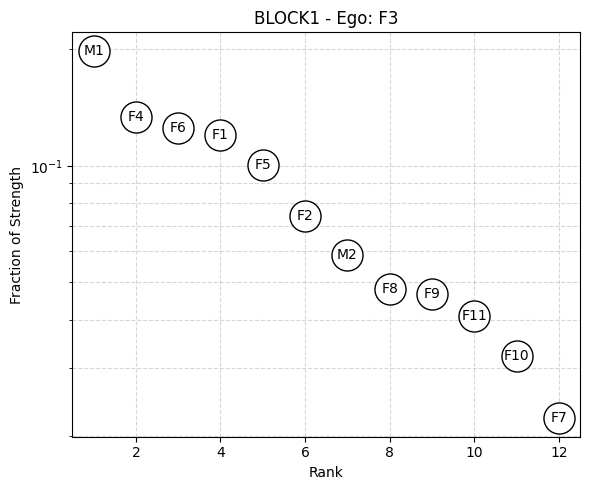

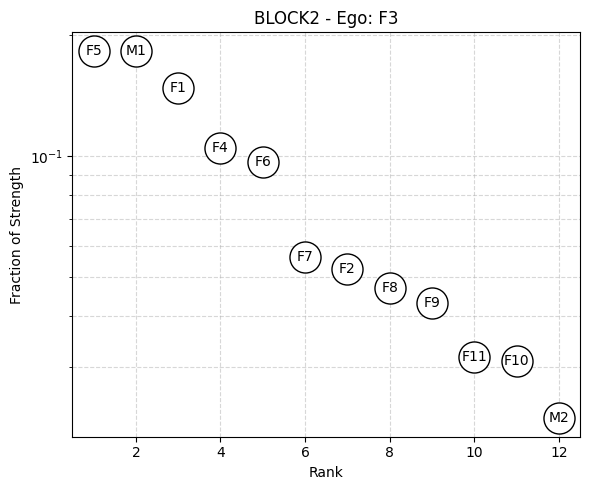

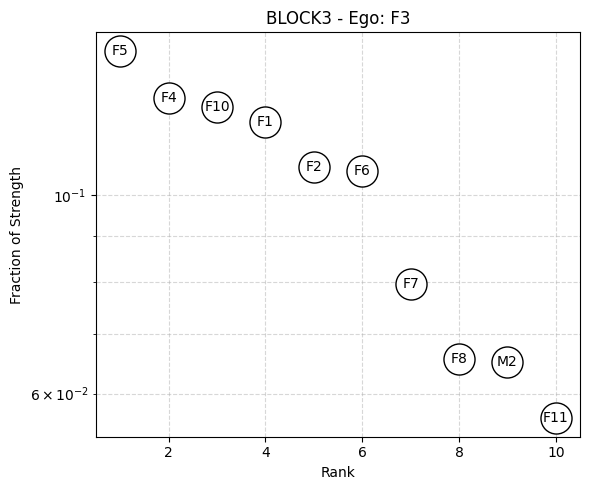

In [ ]:
plot_ego_rank("F3")

### Persistence of top neighbors

In [ ]:
top_neighbors_by_node = defaultdict(dict)

for block_name, G in aggregated_graphs_by_block.items():
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        weighted_neighbors = sorted(
            [(n, G[node][n]['weight']) for n in neighbors],
            key=lambda x: x[1], reverse=True
        )
        top_neighbors = [n for n, _ in weighted_neighbors[:5]]
        top_neighbors_by_node[node][block_name] = set(top_neighbors)


In [ ]:
rows = []
block_sequence = ['block1', 'block2', 'block3']

for node, block_dict in top_neighbors_by_node.items():
    for b1, b2 in zip(block_sequence[:-1], block_sequence[1:]):
        if b1 in block_dict and b2 in block_dict:
            set1 = block_dict[b1]
            set2 = block_dict[b2]
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            jaccard = intersection / union if union > 0 else np.nan

            rows.append({
                'node': node,
                'from_block': b1,
                'to_block': b2,
                'jaccard_index': jaccard
            })

df_jaccard = pd.DataFrame(rows)
df_jaccard

,node,from_block,to_block,jaccard_index
0,F10,block1,block2,0.250000
1,F10,block2,block3,0.250000
2,M1,block1,block2,0.428571
3,F8,block1,block2,0.428571
4,F8,block2,block3,0.428571
5,F7,block1,block2,0.111111
6,F7,block2,block3,0.666667
7,F11,block1,block2,0.250000
8,F11,block2,block3,0.250000
9,F9,block1,block2,0.428571


In [ ]:
df_jaccard.groupby(['from_block', 'to_block'])['jaccard_index'].agg(['mean', 'std'])

,,mean,std
from_block,to_block,,
block1,block2,0.493895,0.234942
block2,block3,0.390693,0.160323


### Correlation of top neighbors retention with rank 

In [ ]:
jaccard_by_node = df_jaccard.groupby("node")["jaccard_index"].mean().reset_index()
jaccard_by_node[["sex", "rank"]] = jaccard_by_node["node"].apply(lambda x: parse_hierarchy(x)).apply(pd.Series)
jaccard_by_node

,node,jaccard_index,sex,rank
0,F1,0.547619,F,1
1,F10,0.250000,F,10
2,F11,0.250000,F,11
3,F2,0.458333,F,2
4,F3,0.714286,F,3
5,F4,0.547619,F,4
6,F5,0.458333,F,5
7,F6,0.339286,F,6
8,F7,0.388889,F,7
9,F8,0.428571,F,8


In [ ]:
jaccard_by_node_f = jaccard_by_node[jaccard_by_node["sex"]=="F"]
permutation_spearman_pvalue(jaccard_by_node_f["rank"], jaccard_by_node_f["jaccard_index"])

(np.float64(-0.8440722199302099), np.float64(0.001))

### Persistence of top neighbors compared to random baseline

In [ ]:
node_pairs = [(n1, n2) for n1 in all_individuals for n2 in all_individuals]

block_pairs = [('block1', 'block2'), ('block2', 'block3')]

rows = []

for n1, n2 in node_pairs:
    for b1, b2 in block_pairs:
        G1 = top_neighbors_by_node[n1]
        G2 = top_neighbors_by_node[n2]
        if b1 not in G1 or b2 not in G2:
            continue
        set1 = top_neighbors_by_node[n1][b1]
        set2 = top_neighbors_by_node[n2][b2]
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        jaccard = intersection / union if union > 0 else np.nan

        rows.append({
            'node1': n1,
            'node2': n2,
            'block1': b1,
            'block2': b2,
            'jaccard': jaccard
        })

df_jaccard = pd.DataFrame(rows)
df_jaccard

,node1,node2,block1,block2,jaccard
0,F5,F5,block1,block2,0.666667
1,F5,F5,block2,block3,0.250000
2,F5,F8,block1,block2,0.428571
3,F5,F8,block2,block3,0.111111
4,F5,F11,block1,block2,0.111111
...,...,...,...,...,...
307,F10,F1,block2,block3,0.250000
308,F10,F4,block1,block2,0.111111
309,F10,F4,block2,block3,0.250000
310,F10,F10,block1,block2,0.250000


In [ ]:
df_jaccard_mean = df_jaccard.groupby(["node1", "node2"])["jaccard"].mean().reset_index()
df_jaccard_self = df_jaccard_mean[df_jaccard_mean["node1"] == df_jaccard_mean["node2"]]
df_jaccard_non_self = df_jaccard_mean[df_jaccard_mean["node1"] != df_jaccard_mean["node2"]]

In [ ]:
df_jaccard_self["jaccard"].mean(), df_jaccard_self["jaccard"].std()

(np.float64(0.44520757020757024), 0.12768628843064164)

In [ ]:
df_jaccard_non_self["jaccard"].mean(), df_jaccard_non_self["jaccard"].std()

(np.float64(0.2724104599104599), 0.11262077376533465)

In [ ]:
def permutation_test_mean_difference(group1, group2, n_permutations=10000, alternative='two-sided', seed=None):
    if seed is not None:
        np.random.seed(seed)

    group1 = np.asarray(group1)
    group2 = np.asarray(group2)

    observed_diff = group1.mean() - group2.mean()
    combined = np.concatenate([group1, group2])
    labels = np.array([1]*len(group1) + [0]*len(group2))

    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(labels)
        perm_group1 = combined[labels == 1]
        perm_group2 = combined[labels == 0]
        diff = perm_group1.mean() - perm_group2.mean()
        perm_diffs.append(diff)

    perm_diffs = np.array(perm_diffs)

    if alternative == 'greater':
        p_val = np.mean(perm_diffs >= observed_diff)
    elif alternative == 'less':
        p_val = np.mean(perm_diffs <= observed_diff)
    else:
        p_val = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))

    return p_val


In [ ]:
permutation_test_mean_difference(df_jaccard_self["jaccard"], df_jaccard_non_self["jaccard"], alternative="greater")

np.float64(0.0)

### Persistence of ego plot shape

In [ ]:
def compare_ego_shapes(G1, ego1, G2, ego2, dim=12):
    if ego1 not in G1 or ego2 not in G2:
        return np.nan

    neighbors1 = dict(G1[ego1])
    neighbors2 = dict(G2[ego2])

    weights1 = [d['weight'] for d in neighbors1.values()]
    weights2 = [d['weight'] for d in neighbors2.values()]

    sum1 = sum(weights1)
    sum2 = sum(weights2)

    if sum1 == 0 or sum2 == 0:
        return np.nan

    vec1 = sorted([w / sum1 for w in weights1], reverse=True)
    vec2 = sorted([w / sum2 for w in weights2], reverse=True)

    vec1 += [0] * (dim - len(vec1))
    vec2 += [0] * (dim - len(vec2))

    vec1 = vec1[:dim]
    vec2 = vec2[:dim]

    return jensenshannon(vec1, vec2)


In [ ]:
node_pairs = [(n1, n2) for n1 in all_individuals for n2 in all_individuals]

block_pairs = [('block1', 'block2'), ('block2', 'block3')]

jsd_res = []

for n1, n2 in node_pairs:
    for b1, b2 in block_pairs:
        G1 = aggregated_graphs_by_block[b1]
        G2 = aggregated_graphs_by_block[b2]

        jsd = compare_ego_shapes(G1, n1, G2, n2, dim=12)

        jsd_res.append({
            "ego1": n1,
            "ego2": n2,
            "block1": b1,
            "block2": b2,
            "jsd": jsd
        })

df_jsd_ego_pairwise = pd.DataFrame(jsd_res)


In [ ]:
df_jsd_ego_pairwise.dropna(inplace=True)
df_jsd_ego_self = df_jsd_ego_pairwise[df_jsd_ego_pairwise["ego1"] == df_jsd_ego_pairwise["ego2"]]
df_jsd_ego_self = df_jsd_ego_self.groupby("ego1")["jsd"].mean().reset_index()
df_jsd_ego_self = df_jsd_ego_self.groupby("ego1")["jsd"].mean().reset_index()
df_jsd_ego_self[["sex", "rank"]] = df_jsd_ego_self["ego1"].apply(lambda x: parse_hierarchy(x)).apply(pd.Series)
df_jsd_ego_self

<ipython-input-247-36d3260a5e13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jsd_ego_self[["sex", "rank"]] = df_jsd_ego_self["ego1"].apply(lambda x: parse_hierarchy(x)).apply(pd.Series)
<ipython-input-247-36d3260a5e13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jsd_ego_self[["sex", "rank"]] = df_jsd_ego_self["ego1"].apply(lambda x: parse_hierarchy(x)).apply(pd.Series)


,ego1,ego2,jsd,sex,rank
0,F1,F1,0.113300,F,1
14,F10,F10,0.130180,F,10
28,F11,F11,0.146946,F,11
42,F2,F2,0.116085,F,2
56,F3,F3,0.120030,F,3
70,F4,F4,0.101002,F,4
84,F5,F5,0.170007,F,5
98,F6,F6,0.107418,F,6
112,F7,F7,0.112168,F,7
126,F8,F8,0.135495,F,8


### Correlation of ego plot shape retention with rank

In [ ]:
df_jsd_ego_self_f = df_jsd_ego_self[df_jsd_ego_self["sex"]=="F"]
permutation_spearman_pvalue(df_jsd_ego_self_f["rank"], df_jsd_ego_self_f["jsd"])

(np.float64(0.20000000000000004), np.float64(0.567))

### Persistance of ego plot shape compared to random baseline

In [ ]:
df_jsd_ego_self = df_jsd_ego_pairwise[df_jsd_ego_pairwise["ego1"] == df_jsd_ego_pairwise["ego2"]]
df_jsd_ego_non_self = df_jsd_ego_pairwise[df_jsd_ego_pairwise["ego1"] != df_jsd_ego_pairwise["ego2"]]

In [ ]:
len(df_jsd_ego_self), len(df_jsd_ego_non_self)

(24, 288)

In [ ]:
df_jsd_ego_pairwise_mean = df_jsd_ego_pairwise.groupby(["ego1", "ego2"])["jsd"].mean().reset_index()
df_jsd_ego_self = df_jsd_ego_pairwise_mean[df_jsd_ego_pairwise_mean["ego1"] == df_jsd_ego_pairwise_mean["ego2"]]
df_jsd_ego_non_self = df_jsd_ego_pairwise_mean[df_jsd_ego_pairwise_mean["ego1"] != df_jsd_ego_pairwise_mean["ego2"]]

In [ ]:
df_jsd_ego_self["jsd"].mean(), df_jsd_ego_self["jsd"].std()

(np.float64(0.11898990501563424), 0.027541077154713735)

In [ ]:
df_jsd_ego_non_self["jsd"].mean(), df_jsd_ego_non_self["jsd"].std()

(np.float64(0.13260261298208925), 0.021666907822350152)

In [ ]:
permutation_test_mean_difference(df_jsd_ego_self["jsd"], df_jsd_ego_non_self["jsd"], alternative="less")

np.float64(0.0176)